# Geospatial Data

In [1]:
import fiona
import folium
import geopandas as gpd
import matplotlib.patches as pt
import matplotlib.pyplot as plt
import numpy as np
from pyproj import CRS, Proj, Transformer
import rasterio
from rasterio.plot import show, show_hist, adjust_band, reshape_as_image
from shapely.geometry import shape, Point, LineString, Polygon
import warnings
warnings.filterwarnings('ignore')

## Raster data

Python module ที่สามารถใช้ประมวลและแสดง raster data เช่น `rasterio`, `matplotlib`

เราจะใช้ภาพส่วนหนึ่งจาก Landsat 7 มีทั้งหมด 8 band (B, G, R, NIR, SWIR1, SWIR2, TIR, cloud)

In [2]:
# Import and open the image dataset
img = rasterio.open("../data/LE70220491999322EDC01_stack.gtif")

In [3]:
# Image attributes
print("Image filename:", img.name, '\n')
print("The number of bands in images:", img.count, '\n') 
print("The number of rows and columns in images:", img.shape, '\n')
print("Raster description:", img.descriptions, '\n')
print("Raster metadata:", img.meta, '\n')
print("Raster driver:", img.driver, '\n')
print("Image projection:", img.crs, '\n')
print("Image geo-transform:"); print(img.transform)

Image filename: ../data/LE70220491999322EDC01_stack.gtif 

The number of bands in images: 8 

The number of rows and columns in images: (250, 250) 

Raster description: ('band 1 reflectance', 'band 2 reflectance', 'band 3 reflectance', 'band 4 reflectance', 'band 5 reflectance', 'band 7 reflectance', 'band 6 temperature', None) 

Raster metadata: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 250, 'height': 250, 'count': 8, 'crs': CRS.from_epsg(32615), 'transform': Affine(30.0, 0.0, 462405.0,
       0.0, -30.0, 1741815.0)} 

Raster driver: GTiff 

Image projection: EPSG:32615 

Image geo-transform:
| 30.00, 0.00, 462405.00|
| 0.00,-30.00, 1741815.00|
| 0.00, 0.00, 1.00|


In [4]:
# Read the 4th band (NIR)
nir = img.read(4)
nir.shape

(250, 250)

In [5]:
# Compute the statistics of the NIR band
print(f"NIR band range: {np.amin(nir)} - {np.amax(nir)}")
print(f"NIR band mean: {np.mean(nir)}")
print(f"NIR band SD: {np.std(nir)}")

NIR band range: 1105 - 5138
NIR band mean: 3442.297712
NIR band SD: 461.0594490687346


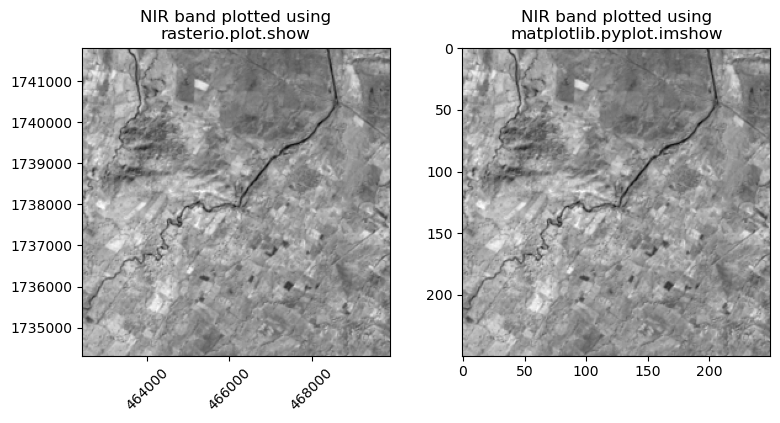

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
# Plot the NIR band using "rasterio.plot.show"
img1 = show(nir, ax=ax1, transform=img.transform, cmap='gray')
ax1.ticklabel_format(style='plain')
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_title("NIR band plotted using\nrasterio.plot.show")
# Plot the NIR band using "matplotlib.pyplot.imshow"
ax2.imshow(nir, cmap='gray')
ax2.set_title("NIR band plotted using\nmatplotlib.pyplot.imshow");

In [7]:
# Read the entire image
full_img = img.read()
full_img.shape  # bands, rows, cols

(8, 250, 250)

In [8]:
# Another way to read the 4th band (NIR) - "read" method is better because it saves on memory
nir = full_img[3, :, :]

In [9]:
# Read the 3th band (Red)
r = img.read(3)

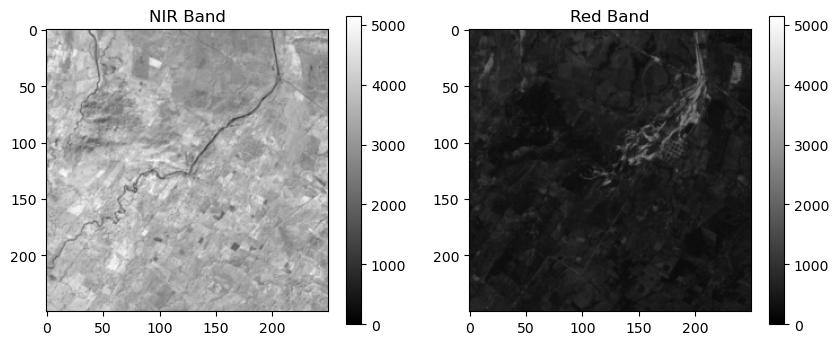

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Find the max reflectance to put them on the same colorbar scale
max_ref = np.amax([np.amax(full_img[3:, :]), np.amax(full_img[2:, :])])

# nir in first subplot
nir_plot = ax1.imshow(nir, cmap="gray")
ax1.set_title("NIR Band")
nir_plot.set_clim(vmin=0, vmax=max_ref)
fig.colorbar(nir_plot, ax=ax1)

# Now red band in the second subplot
r_plot = ax2.imshow(r, cmap="gray")
ax2.set_title("Red Band")
r_plot.set_clim(vmin=0, vmax=max_ref)
fig.colorbar(r_plot, ax=ax2);

In [11]:
# Create a composite image from SWIR1, NIR, and Red (543) bands
composite_img = full_img[[4, 3, 2], :, :].astype(np.float64)

# Enforce maximum and minimum values
max_val = 5000
min_val = 0
composite_img[composite_img[:, :, :] > max_val] = max_val
composite_img[composite_img[:, :, :] < min_val] = min_val

# Normalise each band to 0-1 range
composite_img = adjust_band(composite_img)

# Raster มี shape อยู่ในรูป [bands, rows, cols]
# Images มี shape อยู่ในรูป [rows, cols, bands]
# เราสามารถแปลง raster เป็น image ได้โดยใช้ "rasterio.plot.reshape_as_image"
# และแปลง image เป็น raster ได้โดยใช้ "rasterio.plot.reshape_as_raster"
composite_img_reshaped = reshape_as_image(composite_img)
print(f"Raster shape: {composite_img.shape}, Image shape: {composite_img_reshaped.shape}")

Raster shape: (3, 250, 250), Image shape: (250, 250, 3)


In [12]:
# Define a function to compute NDVI
def calculate_NDVI(nir, r):
    return (nir - r)/(nir + r)

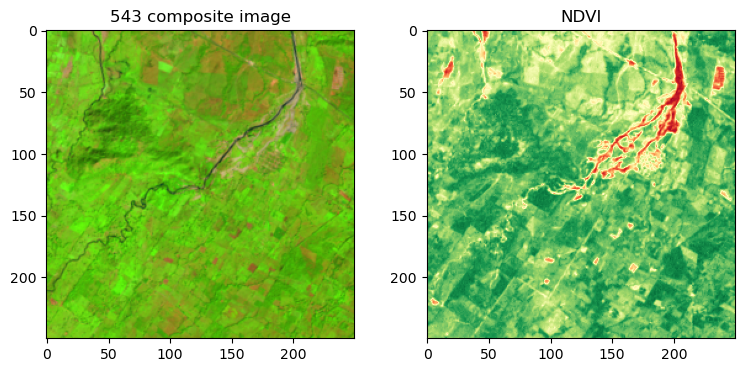

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4)) 

# Show the color composite image
ax1.imshow(composite_img_reshaped)
ax1.set_title('543 composite image')

# Show the NDVI image
# Vegetation has high NDVI; sand and water have low NDVI
ax2.imshow(calculate_NDVI(nir.astype(float), r.astype(float)), cmap="RdYlGn")
ax2.set_title('NDVI');

ต่อไปเราจะใช้ภาพจาก Sentinal-2 และใช้ band 2, 3, 4, 8 (B, G, R, NIR)

In [14]:
bands = [
    "../data/sentinel-2/2018-10-13, Sentinel-2B L1C, B02.tiff",
    "../data/sentinel-2/2018-10-13, Sentinel-2B L1C, B03.tiff",
    "../data/sentinel-2/2018-10-13, Sentinel-2B L1C, B04.tiff",
    "../data/sentinel-2/2018-10-13, Sentinel-2B L1C, B08.tiff"
]

# Open and read each file, and store all bands in a list
band_list = []
for band in bands:
    with rasterio.open(band) as f:
        band_list.append(f.read(1))

# Convert the list to a Numpy array
img = np.array(band_list, dtype=band_list[0].dtype)
img.shape

(4, 2201, 2629)

In [15]:
# Clip images
clipped_img = img[:, :750, :1500]
clipped_img.shape

(4, 750, 1500)

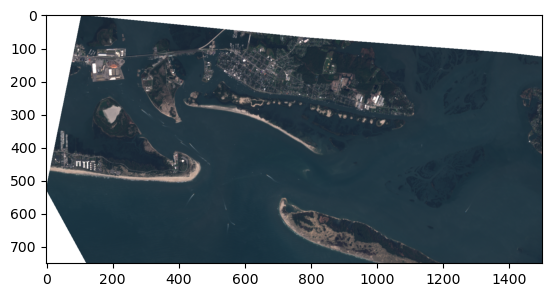

In [16]:
# Display the RGB image
show(clipped_img[[2, 1, 0], :, :]);

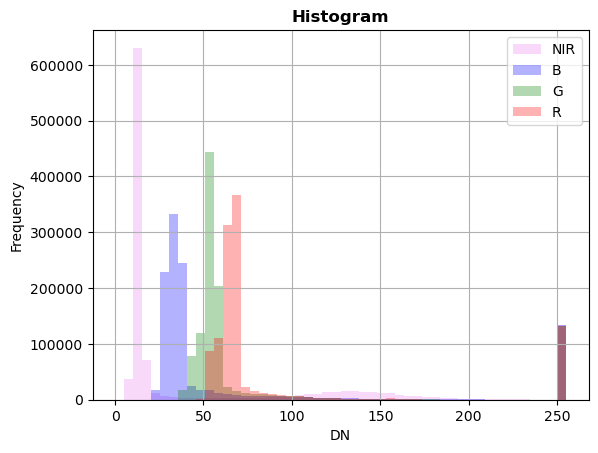

In [17]:
# Plot a histogram of pixel values in each band
rasterio.plot.show_hist(clipped_img,
                        bins=50,
                        histtype='stepfilled',
                        lw=0.0,
                        stacked=False,
                        alpha=0.3,
                        label=["R", "G", "B", "NIR"])

In [18]:
# Areas with no data are labeled 255 on all bands
clipped_img[:, 0, 0]

array([255, 255, 255, 255], dtype=uint8)

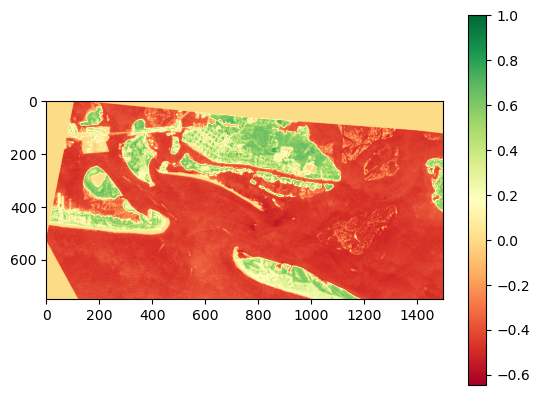

In [19]:
# Ignore the error due to the image having NaN pixels
np.seterr(divide='ignore', invalid='ignore')

# Compute the NDVI image
nir = clipped_img[3].astype(float)
r = clipped_img[2].astype(float)
ndvi = calculate_NDVI(nir, r)

# Plot the NDVI image
# Vegetation has high NDVI; sand and water have low NDVI
plt.imshow(ndvi, cmap="RdYlGn")
plt.colorbar();

## Vector data

Python module ที่สามารถใช้จัดการกับ raster data เช่น `shapely`, `fiona`, `geopandas`

### Plotting vector data

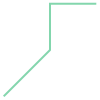

In [20]:
a = LineString([(0, 0), (1, 1), (1,2), (2,2)])
a

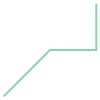

In [21]:
b = LineString([(0, 0), (1, 1), (2,1), (2,2)])
b

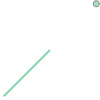

In [22]:
x = b.intersection(a)
x

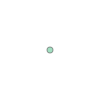

In [23]:
c = Point(1, 1)
c

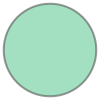

In [24]:
c = c.buffer(1.5)
c

In [25]:
d = Point(2, 1).buffer(1.5)

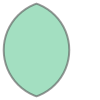

In [26]:
c.intersection(d)

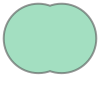

In [27]:
c.union(d)

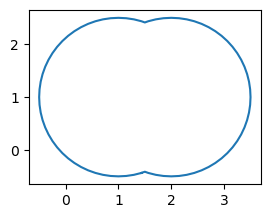

In [28]:
fig, ax = plt.subplots(figsize=(3, 3))
x, y = c.union(d).exterior.xy  # (x, y) along the edge of the shape
ax.plot(x, y)
ax.set_aspect('equal')

<AxesSubplot:>

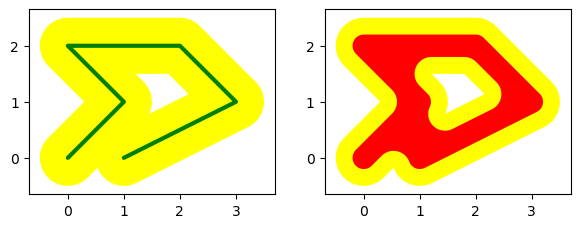

In [29]:
line = LineString([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])  # line
x, y = line.xy  # Get all the points from a "shapely" object

fig, axs = plt.subplots(1,2, figsize=(7, 3))

# Plot the line in the first figure
axs[0].plot(x, y, color='g', linewidth=3, solid_capstyle='round')

# Plot a buffer (a dilated version of the line) in both figures and bring to back by setting zorder=1
# This creates a polygon
dilated = line.buffer(0.5)
gpd.GeoSeries(dilated).plot(ax=axs[0], color='yellow', zorder=1)
gpd.GeoSeries(dilated).plot(ax=axs[1], color='yellow', zorder=1)

# Plot an inner buffer in the second figure
eroded = dilated.buffer(-0.3)
gpd.GeoSeries(eroded).plot(ax=axs[1], color='r')

### Shapefiles

A shapefile is a list of features.

In [30]:
# Open a shapefile dataset - if it cannot be opened, it will be None
shp = fiona.open('../data/rcr/rcr_landcover.shp')
if not shp:
    print('Error: could not open shapefile')

In [31]:
# Shapefile attributes

print("Shapefile driver:", shp.driver, '\n')

print("The number of features of the shapefile:", len(shp), '\n')

print("The shapefile's spatial reference:", shp.crs, '\n')

feature = shp[0]
geometry = feature['geometry']['type']
print("The features's geometry:", geometry, '\n')

properties = feature["properties"].keys()
print("Layer fields:")
for prop in properties:
    print(prop)

print("\nMetadata:"); shp.meta

Shapefile driver: ESRI Shapefile 

The number of features of the shapefile: 23 

The shapefile's spatial reference: EPSG:32618 

The features's geometry: Polygon 

Layer fields:
Classname
Classvalue

Metadata:


{'driver': 'ESRI Shapefile',
 'schema': {'properties': {'Classname': 'str:80', 'Classvalue': 'int:18'},
  'geometry': 'Polygon'},
 'crs': CRS.from_epsg(32618),
 'crs_wkt': 'PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]'}

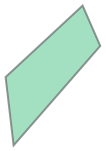

In [32]:
# Transform the geometry into a "shapely" geometry using the "shapely.geometry.shape" function
feature = shp[0]
shapely_shape = shape(feature['geometry'])
shapely_shape

### `geopandas`

`geopandas` มี data structure ที่สำคัญ 2 ชนิด ได้แก่
- `GeoSeries`
    - Series ของ geometry
    - เป็น subclass ของ `pandas.Series`
- `GeoDataFrame`
    - ข้อมูลตารางที่ประกอบด้วย `GeoSeries`
    - เป็น subclass ของ `pandas.DataFrame`
    
เราสามารถจัดการข้อมูล (เช่น indexing, filtering) ได้เหมือนกับใน `pandas`

In [33]:
# Example GeoSeries
p1 = Polygon([(0, 0), (1, 0), (1, 1)])
p2 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p3 = Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])
g = gpd.GeoSeries([p1, p2, p3])
g

0    POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....
1    POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....
2    POLYGON ((2.00000 0.00000, 3.00000 0.00000, 3....
dtype: geometry

In [34]:
# Use a GeoDataFrame of the pre-packaged world dataset
world_path = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_path)
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


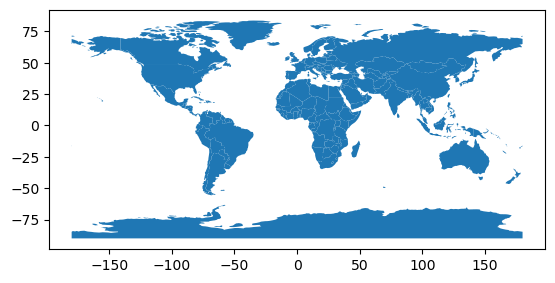

In [35]:
# Plot the GeoDataFrame
world.plot();

In [36]:
# Find all countries with a population greater than 150 million
world[(world["pop_est"] > 150000000)]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
4,3.282395e+08,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
8,2.706256e+08,Asia,Indonesia,IDN,1119190,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ..."
29,2.110495e+08,South America,Brazil,BRA,1839758,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2..."
56,2.009636e+08,Africa,Nigeria,NGA,448120,"POLYGON ((2.69170 6.25882, 2.74906 7.87073, 2...."
98,1.366418e+09,Asia,India,IND,2868929,"POLYGON ((97.32711 28.26158, 97.40256 27.88254..."
99,1.630462e+08,Asia,Bangladesh,BGD,302571,"POLYGON ((92.67272 22.04124, 92.65226 21.32405..."
102,2.165653e+08,Asia,Pakistan,PAK,278221,"POLYGON ((77.83745 35.49401, 76.87172 34.65354..."
139,1.397715e+09,Asia,China,CHN,14342903,"MULTIPOLYGON (((109.47521 18.19770, 108.65521 ..."


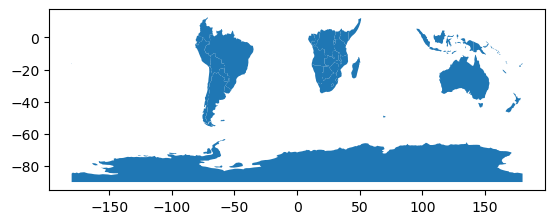

In [37]:
# Plot the southern part
southern_world = world.cx[:, :0]
southern_world.plot();

In [38]:
# Combine the countries from each continent and then sort continents by population
world_filtered = world[['continent', 'geometry', 'pop_est']]
continents = world_filtered.dissolve(by='continent', aggfunc='sum')
continents

,geometry,pop_est
continent,,
Africa,"MULTIPOLYGON (((-11.43878 6.78592, -11.70819 6...",1.306370e+09
Antarctica,"MULTIPOLYGON (((-61.13898 -79.98137, -60.61012...",4.490000e+03
Asia,"MULTIPOLYGON (((48.67923 14.00320, 48.23895 13...",4.550277e+09
Europe,"MULTIPOLYGON (((-53.55484 2.33490, -53.77852 2...",7.454125e+08
North America,"MULTIPOLYGON (((-155.22217 19.23972, -155.5421...",5.837560e+08
Oceania,"MULTIPOLYGON (((147.91405 -43.21152, 147.56456...",4.120487e+07
Seven seas (open ocean),"POLYGON ((68.93500 -48.62500, 69.58000 -48.940...",1.400000e+02
South America,"MULTIPOLYGON (((-68.63999 -55.58002, -69.23210...",4.270667e+08


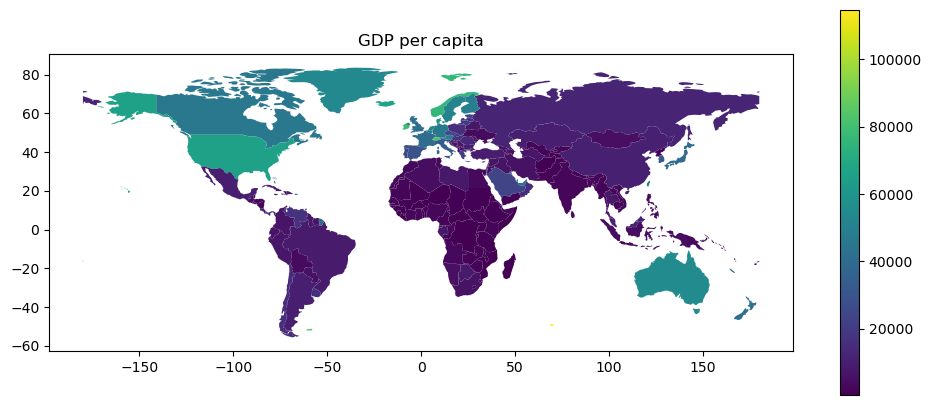

In [39]:
# Calculate and plot by GDP per capita
world = world[(world["pop_est"] > 0) & (world["name"] != "Antarctica")]
world["gdp_per_cap"] = world["gdp_md_est"] / world.pop_est * 1000000  # "gdp_md_est" is million dollars
fig, ax = plt.subplots(figsize=(12, 5))
world.plot(column="gdp_per_cap", legend=True, ax=ax)  # Set the column to be used for the colorbar
ax.set_title("GDP per capita");

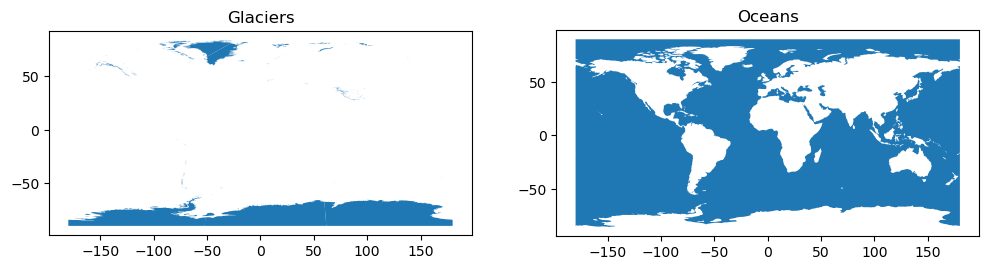

In [40]:
# Import shapefiles of glaciers and oceans
glaciers = gpd.read_file("../data/shapefiles/ne_10m_glaciated_areas.shp")
oceans = gpd.read_file("../data/shapefiles/ne_110m_ocean.shp")

# Plot shapes
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
glaciers.plot(ax=axs[0])
axs[0].set_title("Glaciers")
oceans.plot(ax=axs[1])
axs[1].set_title("Oceans");

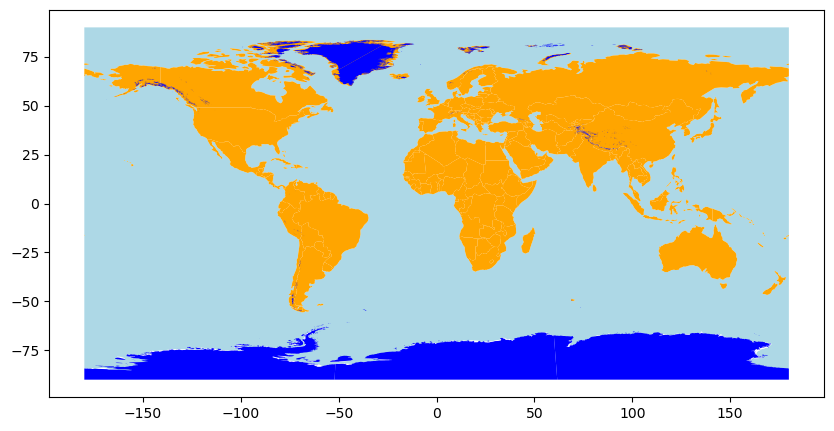

In [41]:
# Plot oceans, world, and glaciers together
fig, ax = plt.subplots(figsize=(10, 6))
oceans.plot(ax=ax, facecolor='lightblue')
world.plot(ax=ax, facecolor='orange')
glaciers.plot(ax=ax, facecolor='blue')
ax.set_aspect('equal')

Note there are some mismatches between the glacier and land datasets because of the different resolutions - see below for an example.

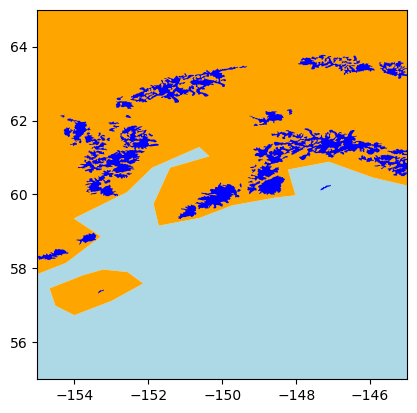

In [42]:
# Plot oceans, world, and glaciers together
fig, ax = plt.subplots()
oceans.plot(ax=ax, facecolor='lightblue')
world.plot(ax=ax, facecolor='orange')
glaciers.plot(ax=ax, facecolor='blue')
ax.set(xlim=[-155, -145], ylim=[55, 65], aspect='equal');

## Combining raster and vector data

In [43]:
# Open a raster dataset
raster = rasterio.open('../data/sentinel-2/2018-10-13, Sentinel-2B L1C, B08.tiff')

In [44]:
# Check the coordinate system used in the raster dataset
raster.crs

CRS.from_epsg(4326)

In [45]:
CRS(raster.crs)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [46]:
# Read a shapefile straight into a GeoDataFrame
shp = gpd.read_file('../data/rcr/rcr_landcover.shp')
shp_filtered = shp.filter(['Classname', 'geometry'])  # Identical to shp[['Classname', 'geometry']]
shp_filtered.head()

,Classname,geometry
0,Sand,"POLYGON ((346494.471 3840484.890, 346512.163 3..."
1,Forested Wetland,"POLYGON ((347156.620 3842382.623, 347140.569 3..."
2,Forested Wetland,"POLYGON ((347374.249 3842272.855, 347343.280 3..."
3,Sand,"POLYGON ((347752.940 3842285.305, 347732.080 3..."
4,Emergent Wetland,"POLYGON ((352462.707 3840569.388, 352421.826 3..."


In [47]:
# Check the coordinate system used in the shapefile
shp.crs  # Identical to pyproj.CRS(shp.crs)

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can see that the raster dataset and the shapefile have different coordinate systems.
- EPSG:4326 is the latitude and longitude coordinates
- EPSG:32618 is UTM 18N

In [48]:
# Get the four corner points of the raster dataset
raster_gps_corners = (
    raster.transform * (0, 0),
    raster.transform * (raster.width, 0),
    raster.transform * (raster.width, raster.height),
    raster.transform * (0, raster.height)
)

# crs
p1 = Proj(raster.crs)  # The current crs (lat, lon)
p2 = Proj(shp.crs)  # The new crs (UTM 18N)

# Use "pyproj.Transformer.transform" to change the crs
transformer = Transformer.from_crs(p1.crs, p2.crs)
UTMx, UTMy = transformer.transform(
    np.array(raster_gps_corners)[:, 1],
    np.array(raster_gps_corners)[:, 0]
)

# Form a list of (easting, northing)
raster_utm_corners = list(zip(UTMx, UTMy))

print('Raster corners in longitudes and latitudes:', raster_gps_corners, '\n')
print('Raster corners in UTM 18N:', raster_utm_corners)

Raster corners in longitudes and latitudes: ((-76.716188, 34.730144), (-76.479982, 34.730144), (-76.479982, 34.567461), (-76.716188, 34.567461)) 

Raster corners in UTM 18N: [(342874.29359233467, 3844458.611782608), (364501.9870325172, 3844114.8502116846), (364236.96553226013, 3826072.8217074675), (342566.93812409707, 3826415.843995134)]


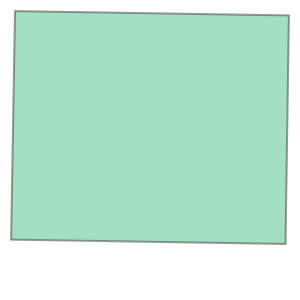

In [49]:
# Create a "shapely" geometry of the raster
raster_geometry = {
    'type': 'Polygon',
    'coordinates': [list(raster_utm_corners)]     
}
raster_shape = shape(raster_geometry)
raster_shape

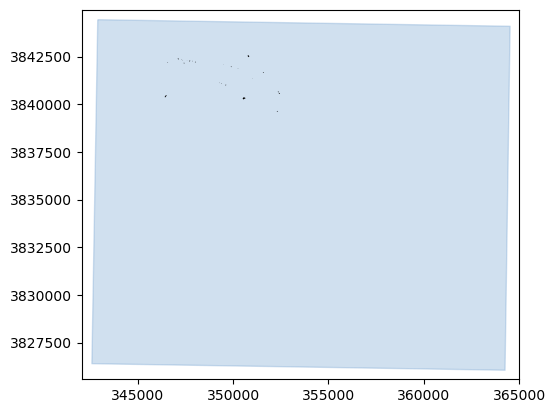

In [50]:
fig, ax = plt.subplots()

gpd.GeoSeries(raster_shape).plot(ax=ax, alpha=0.3, facecolor='#6699cc', edgecolor='#6699cc')
shp.plot(ax=ax, color='k')

xrange = [int(min(raster_shape.exterior.xy[0]))-500, int(max(raster_shape.exterior.xy[0]))+500]
yrange = [int(min(raster_shape.exterior.xy[1]))-500, int(max(raster_shape.exterior.xy[1]))+500]

ax.set_xlim(*xrange)
ax.set_ylim(*yrange)
ax.set_aspect('equal')
ax.ticklabel_format(style='plain');

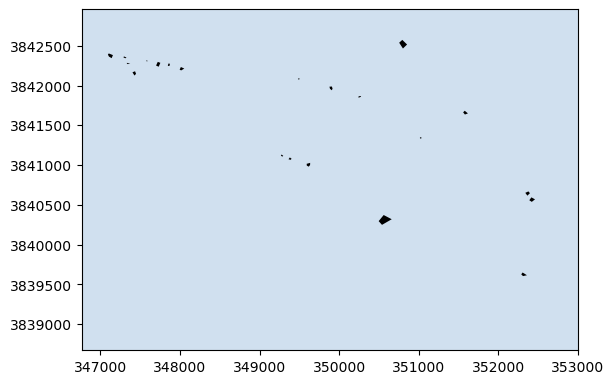

In [51]:
fig, ax = plt.subplots()

gpd.GeoSeries(raster_shape).plot(ax=ax, alpha=0.3, facecolor='#6699cc', edgecolor='#6699cc')
shp.plot(ax=ax, color='k')

# Zoom in
xrange = [int(min(raster_shape.exterior.xy[0]))+4200, int(max(raster_shape.exterior.xy[0]))-11500]
yrange = [int(min(raster_shape.exterior.xy[1]))+12600, int(max(raster_shape.exterior.xy[1]))-1500]

ax.set_xlim(*xrange)
ax.set_ylim(*yrange)
ax.set_aspect('equal')
ax.ticklabel_format(style='plain');

In [52]:
# Create an interactive map using leaflet

# folium requires (lat, long) but "pyproj.Transformer.transform" gives (long, lat)
raster_gps_reversed = list(zip(
    np.array(raster_gps_corners)[:, 1],
    np.array(raster_gps_corners)[:, 0]
))

# Use a point as the center of the map
center = raster_gps_reversed[1] 

# Create the folium map object
m = folium.Map(location=center, zoom_start=11)

# Add the polygon to the map
folium.Polygon(
    raster_gps_reversed,
    popup='Sentinel-2 Image Bounds',
    color='#3186cc',
    fill=True,
    fill_color='#3186cc'
).add_to(m)

for index in range(len(shp)):
    # Pick out each feature by its index
    feature = shp.iloc[index]
    feature_geometry = shape(feature['geometry'])
    feature_name = feature['Classname']
    
    # Have to do error catching because .exterior.xy doesn't work for multipart polygons
    try:
        # Reproject the crs back to (lat, long) as we want to use it in the folium map
        transformer = Transformer.from_crs(p2.crs, p1.crs)
        lats, longs = transformer.transform(
            feature_geometry.exterior.xy[0],
            feature_geometry.exterior.xy[1]
        )
        # Form a list of (lat, long)
        gps_points = list(zip(lats, longs))

        folium.Polygon(
            gps_points,
            tooltip=feature_name,
            color='#000000',
            fill=True,
            fill_color='#99999'
        ).add_to(m)
    except AttributeError:
        pass

m